## Library Import

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from skimpy import skim
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("ggplot")
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_theme(style="white")

import warnings
warnings.filterwarnings('ignore')
mpl.rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', None)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.interpolate import make_interp_spline

import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


## Data Import

In [ ]:
# Surplus Elec
remains = pd.read_csv('/data/surplus_energy')

# Bitcoin Data
bitcoin = pd.read_csv('/data/blockchain_dot_com_daily_data_250109.csv')
bitcoin['datetime'] = pd.to_datetime(bitcoin['datetime'])

In [5]:
bitcoin.tail()

,datetime,mempool_size,transaction_rate,market_cap_usd,average_block_size,market_price_usd,exchange_volume_usd,average_confirmation_time,hash_rate,difficulty,miners_revenue,total_transaction_fees
5840,2024-12-30,68863056.00,3.666667,1.852870e+12,1.759093,93536.42,1.656970e+08,20.443186,8.677102e+08,1.097821e+14,4.708103e+07,7.073408
5841,2024-12-31,62462831.25,3.316667,1.863170e+12,1.730570,92652.68,4.899585e+08,24.562801,7.039913e+08,1.097821e+14,3.839200e+07,5.921379
5842,2025-01-01,59622250.00,2.875000,1.863851e+12,1.811645,93406.74,3.805605e+08,27.536738,7.640215e+08,1.097821e+14,4.167751e+07,4.759661
5843,2025-01-02,52943366.75,3.658333,1.916023e+12,1.709506,94409.13,1.761759e+08,17.681771,9.113685e+08,1.097821e+14,5.085676e+07,5.551069
5844,2025-01-03,61234814.25,4.116667,1.921895e+12,1.735134,96853.63,3.757127e+08,21.029442,7.749361e+08,1.097821e+14,4.377443e+07,6.132099


In [ ]:
data = bitcoin.copy()
data.set_index('datetime', inplace=True)
data = data[data.index <= '2023-12-31']

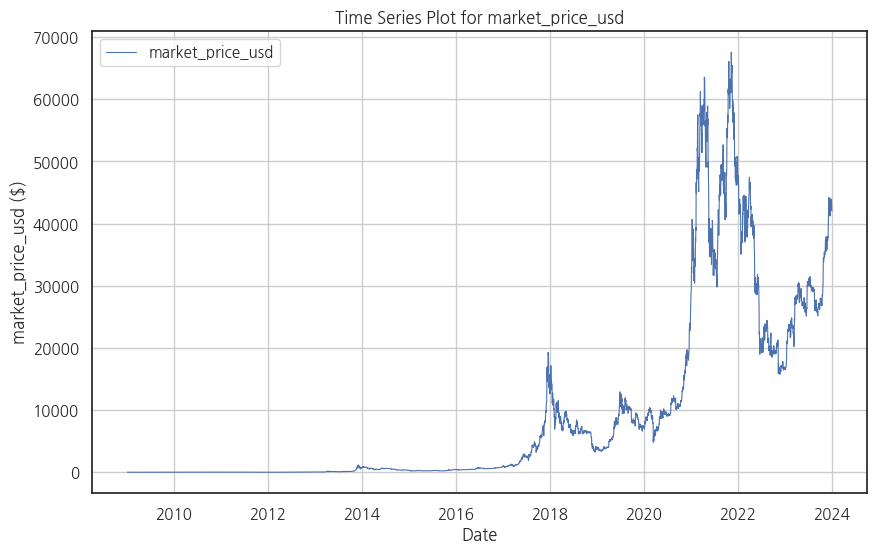

In [ ]:
# whole time
plt.figure(figsize=(10, 6))
plt.plot(data[data.index >= '2009-01-01'].index, data[data.index >= '2009-01-01']['market_price_usd'], label='market_price_usd', linewidth=0.8)
plt.title(f'Time Series Plot for market_price_usd')
plt.xlabel('Date')
plt.ylabel('market_price_usd ($)')
plt.legend()
plt.grid()
plt.show()

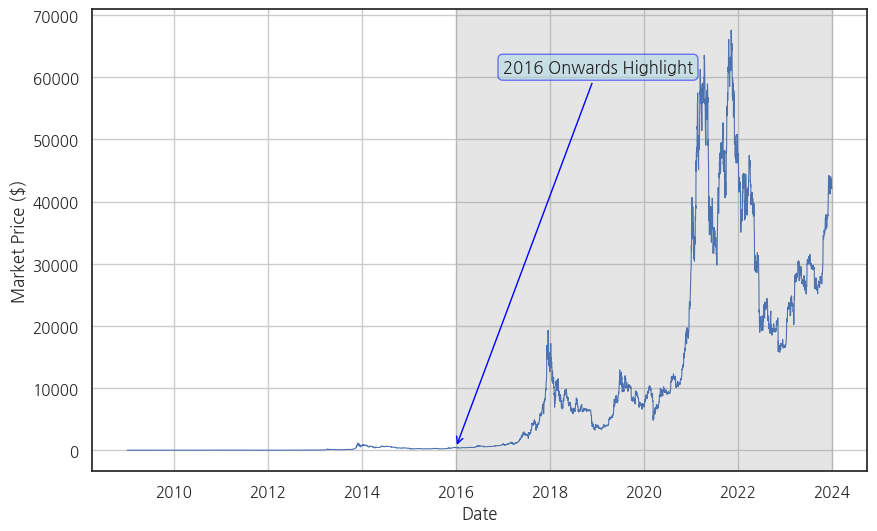

In [ ]:
# copy data to work with
data = data.copy()
data.index = pd.to_datetime(data.index)  # convert index to DatetimeIndex

# datetime64 -> Python datetime convert
data.index = data.index.to_pydatetime()

plt.figure(figsize=(10, 6))

plt.plot(
    data[data.index >= pd.Timestamp('2009-01-01')].index, 
    data[data.index >= pd.Timestamp('2009-01-01')]['market_price_usd'], 
    label='market_price_usd ($)', linewidth=0.8
)

# 2016-01-01: Add a grey background to subsequent data
plt.axvspan(pd.Timestamp('2016-01-01').to_pydatetime(), 
            pd.Timestamp('2023-12-31').to_pydatetime(), 
            color='gray', alpha=0.2, label='2016-01-01 onwards')

# Show blue box
plt.annotate(
    '2016 Onwards Highlight',
    xy=(pd.Timestamp('2016-01-01').to_pydatetime(), data.loc['2016-01-01']['market_price_usd']),
    xytext=(pd.Timestamp('2017-01-01').to_pydatetime(), max(data['market_price_usd']) * 0.9),  # 박스 위치
    bbox=dict(boxstyle='round,pad=0.3', edgecolor='blue', facecolor='lightblue', alpha=0.5),
    arrowprops=dict(arrowstyle='->', color='blue')
)

plt.xlabel('Date')
plt.ylabel('Market Price ($)')
plt.grid()
plt.show()

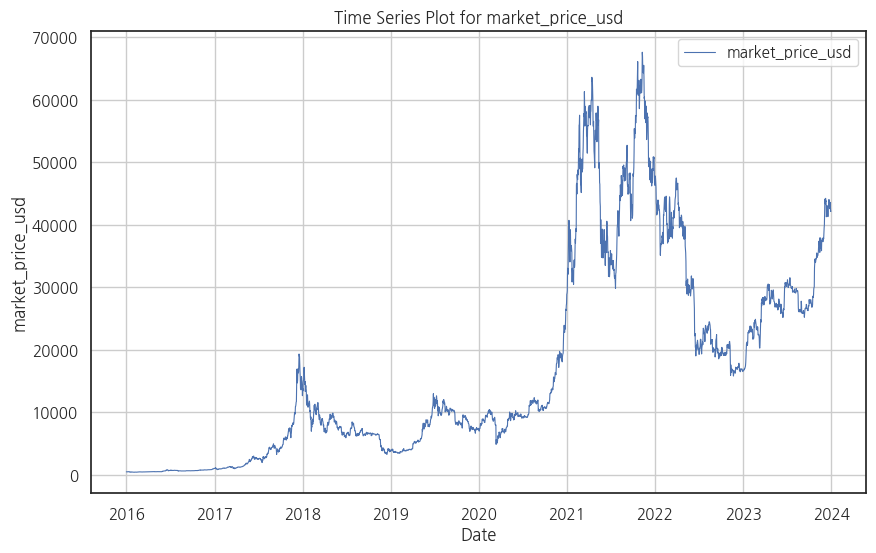

In [13]:
# after 2016
plt.figure(figsize=(10, 6))
plt.plot(data[data.index >= '2016-01-01'].index, data[data.index >= '2016-01-01']['market_price_usd'], label='market_price_usd', linewidth=0.8)
plt.title(f'Time Series Plot for market_price_usd')
plt.xlabel('Date')
plt.ylabel('market_price_usd')
plt.legend()
plt.grid()
plt.show()

In [14]:
bitcoin16 = data[data.index >= '2016-01-01']
bitcoin16.head()

,mempool_size,transaction_rate,market_cap_usd,average_block_size,market_price_usd,exchange_volume_usd,average_confirmation_time,hash_rate,difficulty,miners_revenue,total_transaction_fees
2016-01-01,0.0,0.0,6.505452e+09,0.493407,430.89,2.860153e+06,0.0,697129.166406,1.038803e+11,1.554769e+06,19.820806
2016-01-02,0.0,0.0,6.518218e+09,0.579744,434.75,1.646042e+06,0.0,707457.005908,1.038803e+11,1.671420e+06,31.376005
2016-01-03,0.0,0.0,6.468993e+09,0.554656,432.76,1.287046e+06,0.0,769424.042922,1.038803e+11,1.720316e+06,24.083049
2016-01-04,0.0,0.0,6.499269e+09,0.556970,430.78,1.967359e+06,0.0,903685.956452,1.038803e+11,2.076921e+06,30.746843
2016-01-05,0.0,0.0,6.510605e+09,0.641779,434.17,2.484225e+06,0.0,841718.919438,1.038803e+11,1.819808e+06,32.278467


## Prediction Model
- Random Forest Regressor
- LSTM

In [ ]:
# 1. Simple Moving Average (SMA)
bitcoin16['SMA_14'] = bitcoin16['market_price_usd'].rolling(window=14).mean()

# 2. Weighted Moving Average (WMA)
weights = list(range(1, 15))  # Create 14-day weights
def calculate_wma(prices):
    return (prices * weights).sum() / sum(weights)

bitcoin16['WMA_14'] = bitcoin16['market_price_usd'].rolling(window=14).apply(calculate_wma, raw=True)

# 3. Momentum
bitcoin16['Momentum'] = bitcoin16['market_price_usd'].diff(periods=1)

# 4. Stochastic K% (K%)
low_14 = bitcoin16['market_price_usd'].rolling(window=14).min()
high_14 = bitcoin16['market_price_usd'].rolling(window=14).max()
bitcoin16['K%'] = 100 * ((bitcoin16['market_price_usd'] - low_14) / (high_14 - low_14))

# 5. Stochastic D% (D%)
bitcoin16['D%'] = bitcoin16['K%'].rolling(window=3).mean()

# 6. RSI
delta = bitcoin16['market_price_usd'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# 7. 14-day moving average (Up_t, Down_t)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# 8. RS/RSI
rs = avg_gain / avg_loss
bitcoin16['RSI'] = 100 - (100 / (1 + rs))

bitcoin16[['market_price_usd', 'SMA_14', 'WMA_14', 'Momentum', 'K%', 'D%', 'RSI']].tail() 

,market_price_usd,SMA_14,WMA_14,Momentum,K%,D%,RSI
2023-12-27,42514.79,42809.209286,43019.768857,-1084.82,45.753995,65.189630,55.670703
2023-12-28,43470.76,42850.900000,43107.975619,955.97,80.745833,70.654007,53.300916
2023-12-29,42609.23,42821.327857,43075.752952,-861.53,49.210829,58.570219,47.836127
2023-12-30,42086.22,42832.150000,42977.738571,-523.01,30.066838,53.341166,50.841639
2023-12-31,42148.38,42825.833571,42886.569238,62.16,32.342111,37.206593,49.495317


In [ ]:
# Check the number of missing values
missing_values = bitcoin16.isnull().sum()
missing_values

mempool_size                 0
transaction_rate             0
market_cap_usd               0
average_block_size           0
market_price_usd             0
exchange_volume_usd          0
average_confirmation_time    0
hash_rate                    0
difficulty                   0
miners_revenue               0
total_transaction_fees       0
SMA_14                       0
WMA_14                       0
Momentum                     0
K%                           0
D%                           0
RSI                          0
target                       1
dtype: int64

In [ ]:
# Sort data (sort in chronological order)
bitcoin16 = bitcoin16.sort_index()

# Remove missing values (up to 15 missing values)
bitcoin16 = bitcoin16.dropna()

# Create a Target variable (next day's Bitcoin price)
bitcoin16['target'] = bitcoin16['market_price_usd'].shift(-1)

In [ ]:
# Train: 2016-01-01 ~ 2022-12-31
train_data = bitcoin16.loc['2016-01-16':'2022-12-31']

# Test: 2023-01-01 ~ 2023-12-30
test_data = bitcoin16.loc['2023-01-01':'2023-12-30']

In [ ]:
# Split Feature/ Target
features = ['SMA_14', 'WMA_14', 'Momentum', 'K%', 'D%', 'RSI']
X_train = train_data[features]
y_train = train_data['target']

X_test = test_data[features]
y_test = test_data['target']

### Random Forest

In [ ]:
# Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Predict with the best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

python(1795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(1802) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Mean Absolute Error (MAE): 1329.13
Mean Squared Error (MSE): 2909857.51
R² Score: 0.91


In [489]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 4.64%


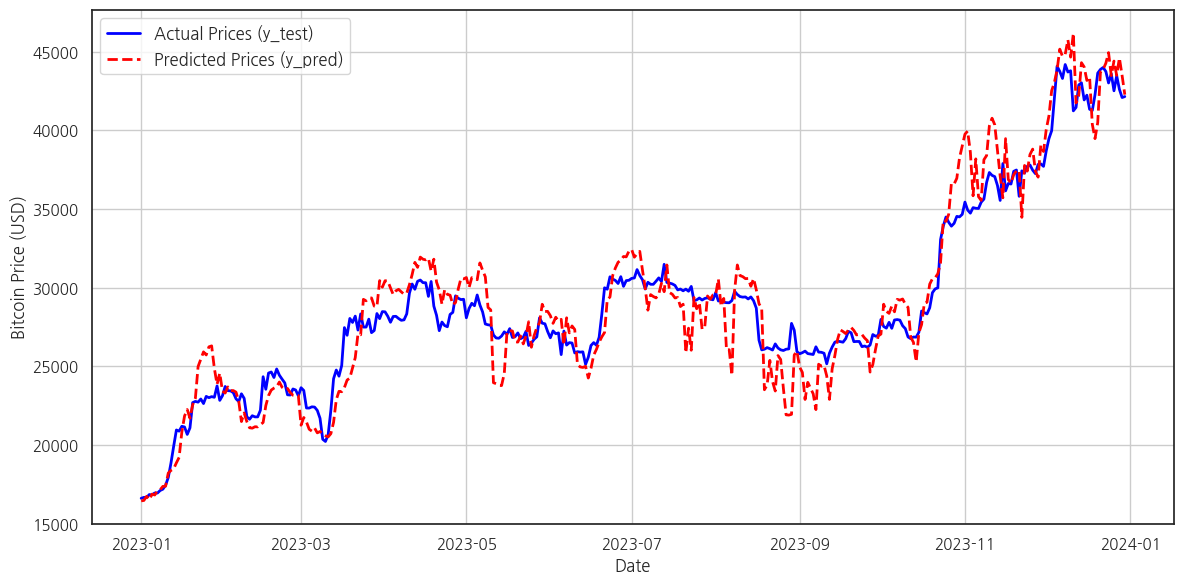

In [ ]:
# y_test와 y_pred (x: date)
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Prices (y_test)', color='blue', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted Prices (y_pred)', color='red', linestyle='--', linewidth=2)
# plt.title('Actual vs Predicted Bitcoin Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bitcoin Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

### LSTM

In [ ]:
# Feature Engineering
# features = ['SMA_14', 'RSI', 'MACD', 'Momentum']  # Independent variables to use
features = ['SMA_14', 'WMA_14', 'Momentum', 'K%', 'D%', 'RSI']

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[features + ['target']])
test_scaled = scaler.transform(test_data[features + ['target']])

# Time series data generation functions
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, :-1]) 
        y.append(data[i + seq_length, -1]) # target value
    return np.array(X), np.array(y)

# Creating time series data
seq_length = 14
X_train_lstm, y_train_lstm = create_sequences(train_scaled, seq_length)
X_test_lstm, y_test_lstm = create_sequences(test_scaled, seq_length)

# Defining the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1)) # the target is a single variable
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Learn the model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, verbose=1)

Epoch 1/20


2025-02-08 21:22:01.424267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-02-08 21:22:01.706886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-02-08 21:22:01.907847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-02-08 21:22:02.088839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-02-08 21:22:02.394035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 4s 17ms/step - loss: 0.0107
Epoch 2/20
79/79 [==============================] - 1s 16ms/step - loss: 0.0017
Epoch 3/20
79/79 [==============================] - 1s 18ms/step - loss: 0.0016
Epoch 4/20
79/79 [==============================] - 1s 18ms/step - loss: 0.0012
Epoch 5/20
79/79 [==============================] - 1s 18ms/step - loss: 9.6291e-04
Epoch 6/20
79/79 [==============================] - 2s 23ms/step - loss: 8.1464e-04
Epoch 7/20
79/79 [==============================] - 1s 19ms/step - loss: 8.1926e-04
Epoch 8/20
79/79 [==============================] - 2s 22ms/step - loss: 7.8965e-04
Epoch 9/20
79/79 [==============================] - 2s 26ms/step - loss: 8.5329e-04
Epoch 10/20
79/79 [==============================] - 1s 17ms/step - loss: 7.5689e-04
Epoch 11/20
79/79 [==============================] - 2s 19ms/step - loss: 6.8069e-04
Epoch 12/20
79/79 [==============================] - 1s 16ms/step - loss: 7.0696e-04
Epoch 13/20
79/7

In [ ]:
# Predict 
y_pred_lstm = model_lstm.predict(X_test_lstm) # model_lstm

# Inverse Scailing
y_pred_actual = scaler.inverse_transform(np.hstack([np.zeros((y_pred_lstm.shape[0], len(features))), y_pred_lstm]))[:, -1]
y_test_actual = scaler.inverse_transform(np.hstack([np.zeros((y_test_lstm.shape[0], len(features))), y_test_lstm.reshape(-1, 1)]))[:, -1]

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f"RMSE: {rmse:.2f}")

2025-02-08 21:22:45.840372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-02-08 21:22:45.966622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/11 [====================>.........] - ETA: 0s

2025-02-08 21:22:46.117339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 47ms/step
RMSE: 2154.95


In [ ]:
# Calculating metrics
mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 1735.92
Mean Squared Error (MSE): 4643802.01
R² Score: 0.85


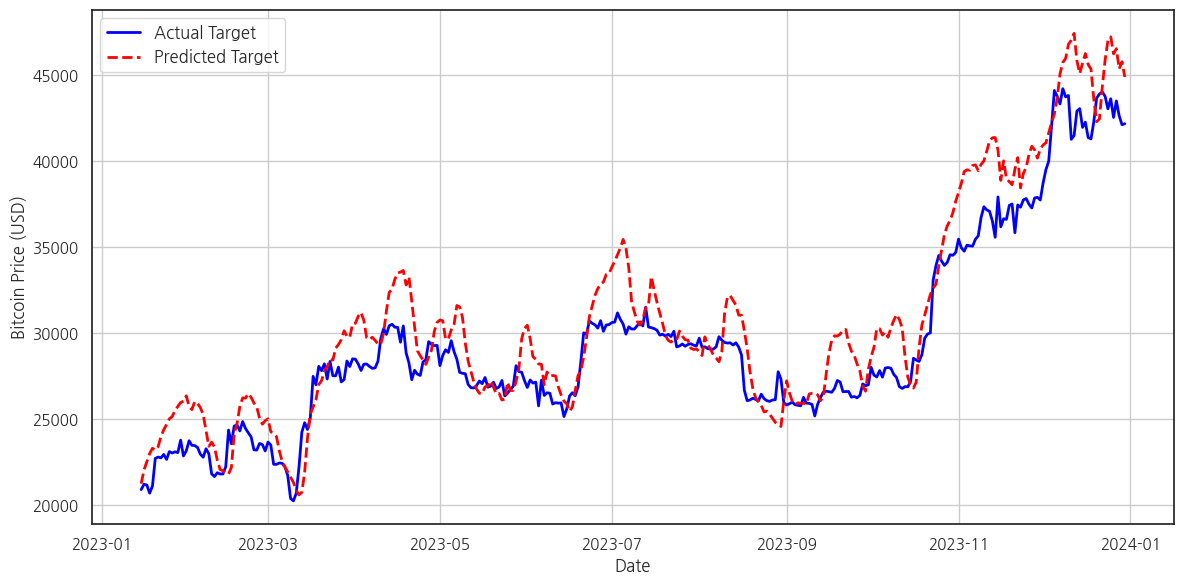

In [ ]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[-len(y_test_actual):], y_test_actual, label='Actual Target', color='blue', linewidth=2)
plt.plot(test_data.index[-len(y_pred_actual):], y_pred_actual, label='Predicted Target', color='red', linestyle='--', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bitcoin Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

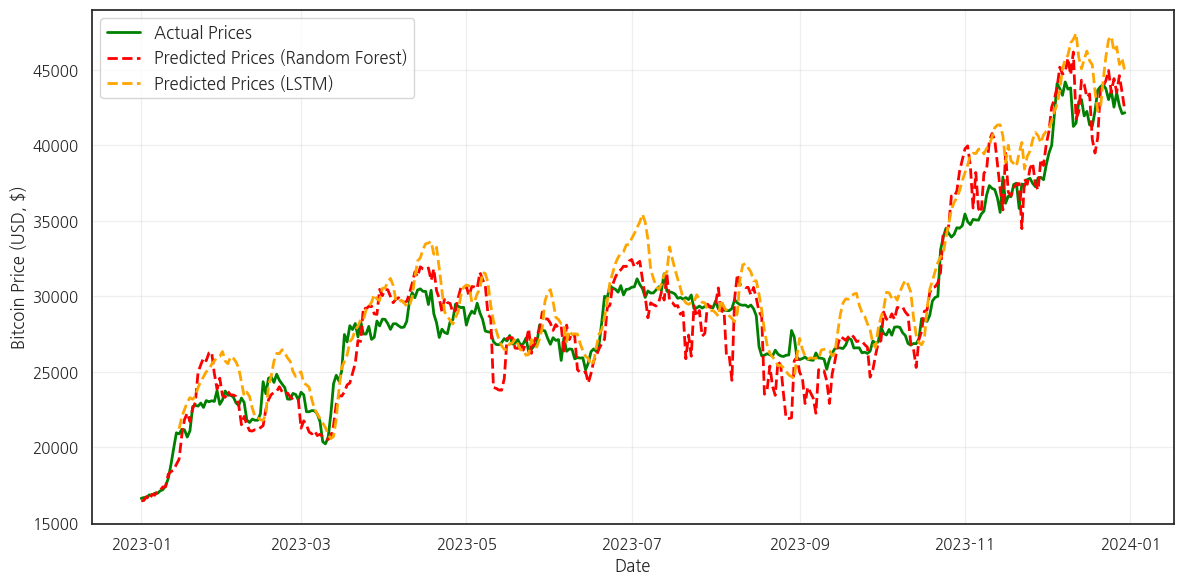

In [ ]:
plt.figure(figsize=(12, 6))

# Random Forest Results
plt.plot(y_test.index, y_test, label='Actual Prices', color='green', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted Prices (Random Forest)', color='red', linestyle='--', linewidth=2)

# LSTM Results
plt.plot(test_data.index[-len(y_pred_actual):], y_pred_actual, label='Predicted Prices (LSTM)', color='orange', linestyle='--', linewidth=2)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bitcoin Price (USD, $)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Expected Mining Value

## Surplus Electricity

In [ ]:
remains_copy = remains.copy()

# Create unique locations (province + city + county + state)
remains_copy['location'] = remains_copy['시도'] + ' ' + remains_copy['시군구']
remains_copy = remains_copy.dropna(subset=['잉여전력량'])

In [9]:
skim(remains_copy)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 154170 │ │ string      │ 5     │                                                          │
│ │ Number of columns │ 8      │ │ int64       │ 2     │                                                          │
│ └───────────────────┴────────┘ │ float64     │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name    ┃ NA  ┃ NA %   ┃ mean    ┃ sd       ┃ p0    ┃ p25   ┃ p50     ┃ p75    ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ 년도           │   0 │      0 │    2022 │   0.8165 │  2021 │  2021 │    2022 │   2023 │      2023 │ ▇  ▇ ▇ │  │
│ │ 월             │   0 │      0 │   6.507 │    3.453 │     1 │     4 │       7 │     10 │        12 │ ▇▇▇▇▇▇ │  │
│ │ 잉여전력량     │   0 │      0 │   29290 │    37910 │    79 │  5209 │   15140 │  39100 │   1055000 │   ▇    │  │
│ └────────────────┴─────┴────────┴─────────┴──────────┴───────┴───────┴─────────┴────────┴───────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA       ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ 시도                     │        0 │          0 │                            1 │                   154170 │  │
│ │ 시군구                   │      716 │       0.46 │                          1.1 │                   174219 │  │
│ │ 법정동                   │        0 │          0 │                            1 │                   154170 │  │
│ │ 전체호수                 │        0 │          0 │                            1 │                   154170 │  │
│ │ location                 │      716 │       0.46 │                          2.1 │                   327673 │  │
│ └──────────────────────────┴──────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [ ]:
# Sejong City
remains_copy.loc[remains_copy['시도'] == '세종특별자치시', '시군구'] = '세종특별자치시'

# Gyeongsangbuk-do Gunwi-gun (27) changed to Daegu Metropolitan City Gunwi-gun (9)
remains_copy.loc[remains_copy['시군구'] == '군위군', '시도'] = '대구광역시'

# Solve Bucheon City (3 Wonmi-gu, etc. > combine into Bucheon City) -- Fit to GEODATA

remains_copy.loc[
    remains_copy['시군구'].str.contains('소사구|오정구|원미구', na=False), 
    '시군구'
] = '부천시'

In [14]:
# Convert total households and surplus power to numerical data
remains_copy['전체호수'] = pd.to_numeric(remains_copy['전체호수'], errors='coerce')
remains_copy['잉여전력량'] = pd.to_numeric(remains_copy['잉여전력량'], errors='coerce')

In [15]:
remains_new = pd.DataFrame(remains_copy[['시도','시군구','년도','월','전체호수','잉여전력량']].groupby(['시도','시군구','년도','월']).agg({'전체호수':'sum',
                                                                                                                '잉여전력량':'sum'}).reset_index(drop=False))
remains_new['location'] = remains_new['시도'] + ' ' + remains_new['시군구']
remains_new.head()

,시도,시군구,년도,월,전체호수,잉여전력량,location
0,강원특별자치도,강릉시,2021,1,3448,559188.0,강원특별자치도 강릉시
1,강원특별자치도,강릉시,2021,2,3477,600713.0,강원특별자치도 강릉시
2,강원특별자치도,강릉시,2021,3,3493,629271.0,강원특별자치도 강릉시
3,강원특별자치도,강릉시,2021,4,3528,990485.0,강원특별자치도 강릉시
4,강원특별자치도,강릉시,2021,5,3533,988600.0,강원특별자치도 강릉시


In [17]:
signgu = pd.read_excel('/data/signgu')
signgu['location'] = signgu['SIDO'] + ' ' + signgu['GUNGU']
signgu.head()

,SIDO,GUNGU,Code,location
0,서울특별시,종로구,11110,서울특별시 종로구
1,서울특별시,중구,11140,서울특별시 중구
2,서울특별시,용산구,11170,서울특별시 용산구
3,서울특별시,성동구,11200,서울특별시 성동구
4,서울특별시,광진구,11215,서울특별시 광진구


In [19]:
remains_new = pd.merge(remains_new, signgu[['location', 'Code']], on='location', how='left')
remains_new

,시도,시군구,년도,월,전체호수,잉여전력량,location,Code
0,강원특별자치도,강릉시,2021,1,3448,559188.0,강원특별자치도 강릉시,51150
1,강원특별자치도,강릉시,2021,2,3477,600713.0,강원특별자치도 강릉시,51150
2,강원특별자치도,강릉시,2021,3,3493,629271.0,강원특별자치도 강릉시,51150
3,강원특별자치도,강릉시,2021,4,3528,990485.0,강원특별자치도 강릉시,51150
4,강원특별자치도,강릉시,2021,5,3533,988600.0,강원특별자치도 강릉시,51150
...,...,...,...,...,...,...,...,...
8995,충청북도,충주시,2023,8,7457,1426853.0,충청북도 충주시,43130
8996,충청북도,충주시,2023,9,7518,1549454.0,충청북도 충주시,43130
8997,충청북도,충주시,2023,10,7562,1574730.0,충청북도 충주시,43130
8998,충청북도,충주시,2023,11,7579,1517908.0,충청북도 충주시,43130


In [ ]:
# GeoJSON file path
geojson_path = '/data/signgu_geojson_20241125.geojson'

# GeoJSON Data load
geodata = gpd.read_file(geojson_path)
geodata = gpd.GeoDataFrame(geodata, geometry=geodata['geometry'])

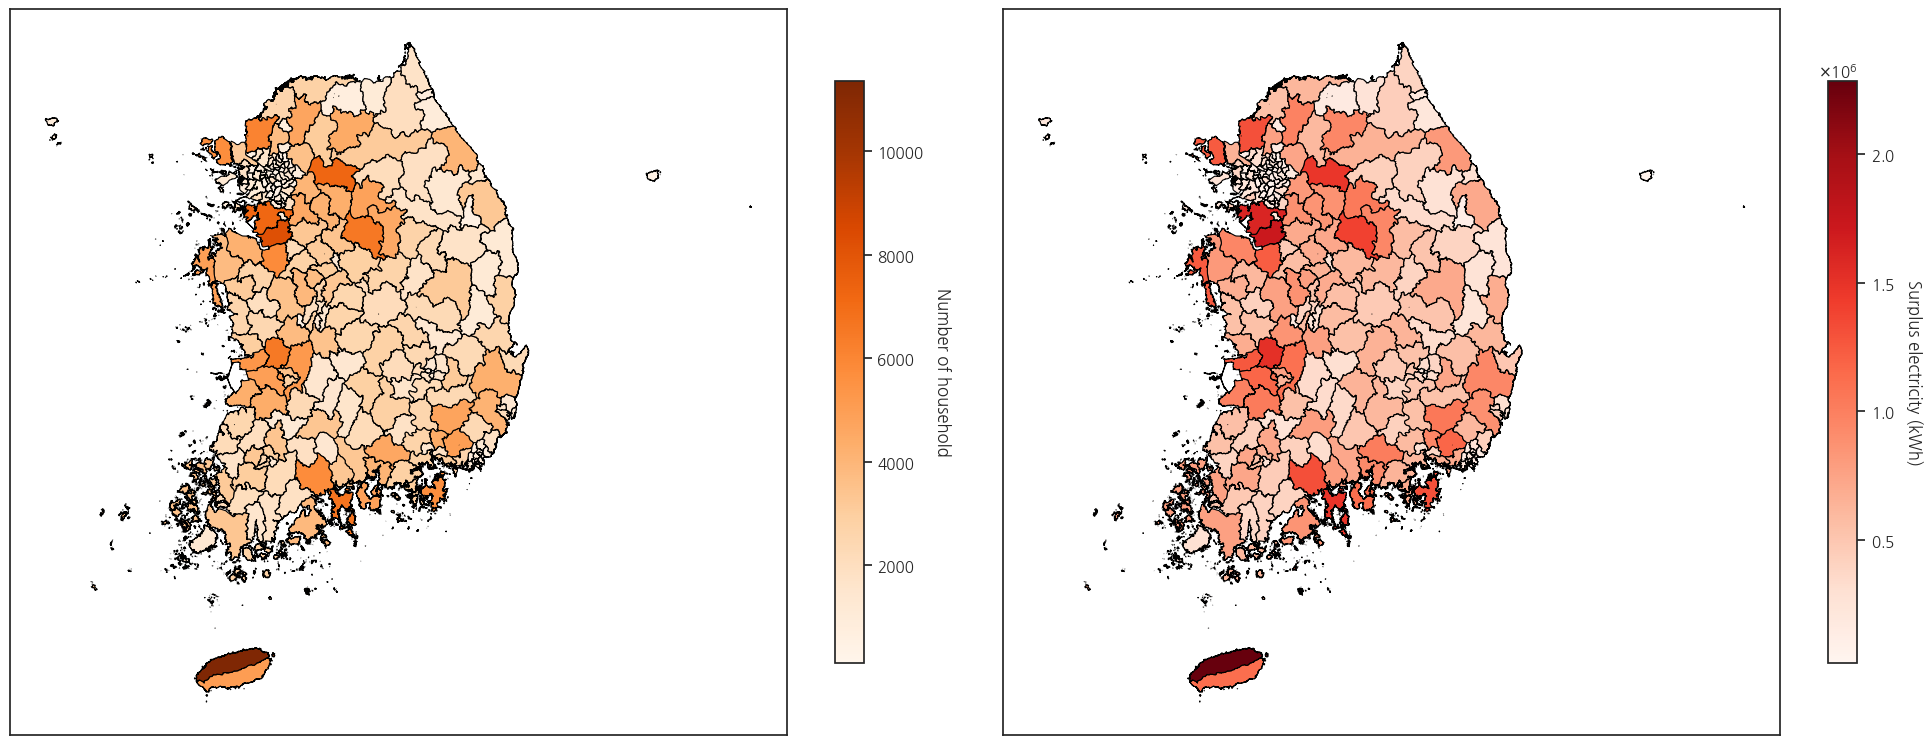

In [ ]:
# Calculate the number of available units per year and month for all data

geodata['날짜'] = pd.to_datetime(geodata['년도'].astype(str) + '-' + geodata['월'].astype(str))
mean_house = pd.DataFrame(geodata.groupby(['시도','시군구','Code','geometry'])['전체호수'].mean()).reset_index(drop=False)
mean_elec = pd.DataFrame(geodata.groupby(['시도','시군구','Code','geometry'])['잉여전력량'].mean()).reset_index(drop=False)

mean_house = gpd.GeoDataFrame(mean_house, geometry=mean_house['geometry'])
mean_elec = gpd.GeoDataFrame(mean_elec, geometry=mean_elec['geometry'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

cmap1 = plt.cm.Oranges
cmap2 = plt.cm.Reds
norm1 = mcolors.Normalize(vmin=mean_house['전체호수'].min(), vmax=mean_house['전체호수'].max())
norm2 = mcolors.Normalize(vmin=mean_elec['잉여전력량'].min(), vmax=mean_elec['잉여전력량'].max())

geodata['날짜'] = pd.to_datetime(geodata['년도'].astype(str) + '-' + geodata['월'].astype(str))
mean_house = pd.DataFrame(geodata.groupby(['시도','시군구','Code','geometry'])['전체호수'].mean()).reset_index(drop=False)
mean_elec = pd.DataFrame(geodata.groupby(['시도','시군구','Code','geometry'])['잉여전력량'].mean()).reset_index(drop=False)

mean_house = gpd.GeoDataFrame(mean_house, geometry=mean_house['geometry'])
mean_elec = gpd.GeoDataFrame(mean_elec, geometry=mean_elec['geometry'])

# Households
mean_house.plot(
    column="전체호수",
    cmap=cmap1,
    linewidth=0.8,
    edgecolor='black',
    ax=ax1,
    legend=False,
    norm=norm1
)
sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=norm1)
sm1._A = []
cbar1 = plt.colorbar(sm1, ax=ax1, shrink=0.5)
cbar1.set_label('Number of household', rotation=270, labelpad=20)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

# Surplus power
mean_elec.plot(
    column="잉여전력량",
    cmap=cmap2,
    linewidth=0.8,
    edgecolor='black',
    ax=ax2,
    legend=False,
    norm=norm2
)
sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=norm2)
sm2._A = []
cbar2 = plt.colorbar(sm2, ax=ax2, shrink=0.5)
cbar2.set_label('Surplus electricity (kWh)', rotation=270, labelpad=20)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

for cbar in [cbar2]:
    cbar.formatter = mticker.ScalarFormatter(useMathText=True)
    cbar.formatter.set_powerlimits((6, 6))
    cbar.update_ticks()

plt.tight_layout()
plt.show()

### Surplus power time series

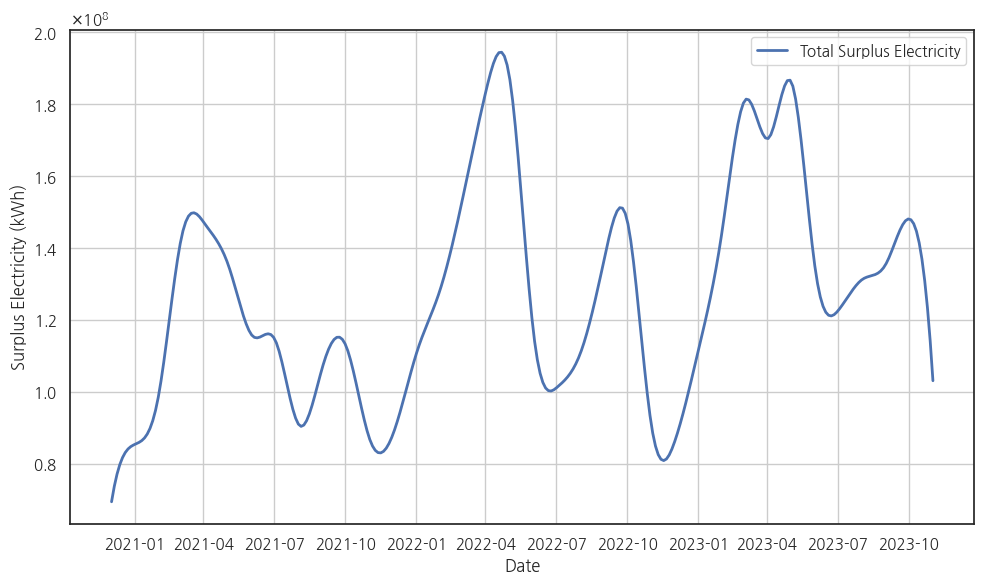

In [ ]:
# Combine 'year' and 'month' to create time series data
remains_new['날짜'] = pd.to_datetime(remains_new['년도'].astype(str) + '-' + remains_new['월'].astype(str))

# Calculate the sum of surplus power by year and month for all data
total_power = remains_new.groupby('날짜')['잉여전력량'].sum()

x = total_power.index  # DatetimeIndex
y = total_power.values  # Surplus power

# Convert X to a numeric value (splines work on a numeric basis)
x_numeric = np.arange(len(x))

# Spline interpolation
x_smooth_numeric = np.linspace(x_numeric.min(), x_numeric.max(), 300)
spline = make_interp_spline(x_numeric, y, k=3)
y_smooth = spline(x_smooth_numeric)

x_smooth_dates = np.linspace(x.min().value, x.max().value, 300)  # Convert Timestamp to int
x_smooth_dates = pd.to_datetime(x_smooth_dates)  # Convert back to date

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(x_smooth_dates, y_smooth,  label='Total Surplus Electricity', linewidth=2)

# Generate dates at 3-month intervals (based on the end of the month, adjustable to '3MS' etc. as required)
tick_dates = pd.date_range(start=x.min(), end=x.max(), freq='3M')
# x-axis scale and labelling (labels are formatted as 'YYYY-MM' for example)
plt.xticks(ticks=tick_dates, labels=tick_dates.strftime('%Y-%m'))

ax = plt.gca()
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((8, 8))
ax.yaxis.set_major_formatter(formatter)

# plt.title('The amount of surplus electricity generated by home solar generator')
plt.xlabel('Date')
plt.ylabel('Surplus Electricity (kWh)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

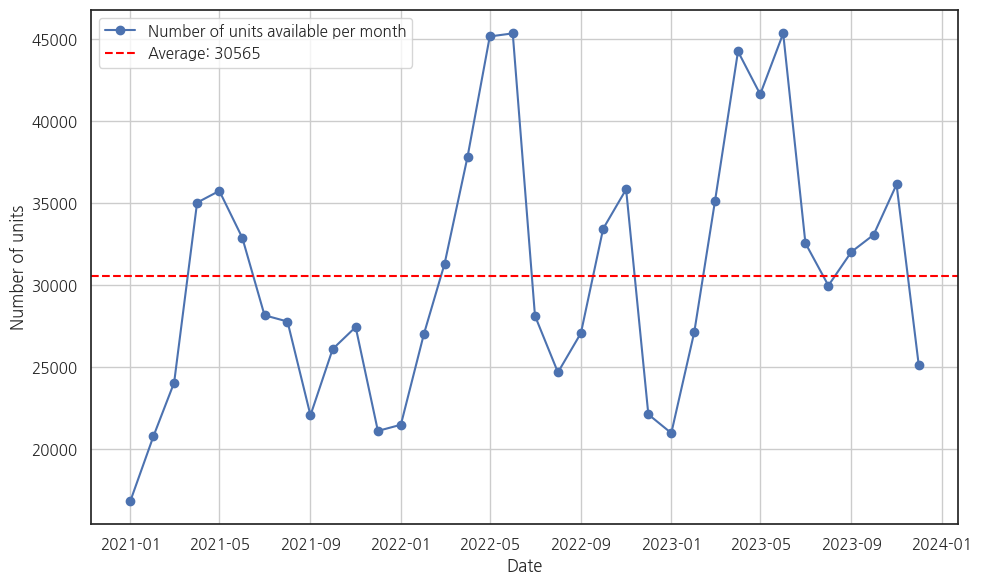

In [ ]:
# Calculating the available miner
remains_new['가동가능대수'] = (remains_new['잉여전력량'] / (5.676 * 24 * 30) ).astype(int)

# Calculate the number of available units per year and month for all data
total_miner = remains_new.groupby('날짜')['가동가능대수'].sum()

# Calculate average
average_units = total_miner.values.mean()

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(total_miner.index, total_miner.values, marker='o', label='Number of units available per month')

# Add axhline of average value
plt.axhline(y=average_units, color='red', linestyle='--', label=f'Average: {average_units:.0f}')

plt.xlabel('Date')
plt.ylabel('Number of units')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Expected number of mines
- Power data
    - Available offsetting power (kW)
    - Power consumption of mining rigs (W/TH or kw/machine)
        - Power efficiency of each rig used for mining (e.g. J/TH, hashrate per watt)
        - Power consumption = number of rigs X power consumption per rig
        - In this data, **5,676 Watt**.
    - Hours of availability of unaccounted-for power
        - This is assumed to be 24/7
- Data on mining rigs
    - Performance of mining rigs (TH/s, hash rate)
        - = the amount of calculations the rig can perform per second
        - In this data, **473 TH/s**.
    - Power efficiency of the rig (J/TH)
        - = how much power the rig consumes based on its hash rate
        - If = 20J/TH, then a 140 TH/s machine consumes 140×20=2800W
        - In this data, **12 J/T**
- Bitcoin Network Data
    - Current Bitcoin network hash rate (H/s)
        - Total network hash rate
        - ex. 400 EH/s
    - Current mining difficulty
        - The amount of computation required to mine a block on the Bitcoin network
    - Bitcoin block generation time
        - Generation time per block is fixed at approximately 10 minutes
    - Block reward
        - Number of bitcoins generated when mining one block
        - Fixed at 6.25 for this data (12 May 2020 - 20 April 2024)
- Current Bitcoin market price (using 2023 forecast)


- https://www.blockchain.com/explorer/charts/hash-rate

In [507]:
remains_grp = remains_new.groupby(['년도','월']).agg({'잉여전력량':'sum'}).reset_index(drop=False)
remains_grp.head()

,년도,월,잉여전력량
0,2021,1,69420961.0
1,2021,2,85415015.0
2,2021,3,98819831.0
3,2021,4,143605083.0
4,2021,5,146507105.0


In [508]:
bitcoin_target_columns = ['datetime','market_price_usd', 'hash_rate', 'difficulty']
bitcoin_target_datetime = ['2021-01-01', '2023-12-31']
bitcoin_target_df = bitcoin[bitcoin_target_columns].loc[
    (bitcoin['datetime'] >= bitcoin_target_datetime[0]) & 
    (bitcoin['datetime'] <= bitcoin_target_datetime[1])
].reset_index(drop=True)

In [ ]:
# Transmission line loss rate
elecloss = 3.59 # KEPCO 10-year average
bitcoin_target_df['년도'] = bitcoin_target_df['datetime'].dt.year
bitcoin_target_df['월'] = bitcoin_target_df['datetime'].dt.month
merged_df = pd.merge(bitcoin_target_df,remains_grp, on=['년도', '월'], how='left')
merged_df['잉여전력량_일별'] = (merged_df['잉여전력량'] * (1-elecloss*0.01) / merged_df['datetime'].dt.days_in_month).astype(int)
merged_df

,datetime,market_price_usd,hash_rate,difficulty,년도,월,잉여전력량,잉여전력량_일별
0,2021-01-01,28982.56,1.377640e+08,1.859959e+13,2021,1,69420961.0,2158991
1,2021-01-02,29393.75,1.396132e+08,1.859959e+13,2021,1,69420961.0,2158991
2,2021-01-03,32195.46,1.460853e+08,1.859959e+13,2021,1,69420961.0,2158991
3,2021-01-04,33000.78,1.599542e+08,1.859959e+13,2021,1,69420961.0,2158991
4,2021-01-05,32035.03,1.451608e+08,1.859959e+13,2021,1,69420961.0,2158991
...,...,...,...,...,...,...,...,...
1090,2023-12-27,42514.79,4.617484e+08,7.200615e+13,2023,12,103099672.0,3206399
1091,2023-12-28,43470.76,4.331128e+08,7.200615e+13,2023,12,103099672.0,3206399
1092,2023-12-29,42609.23,5.404962e+08,7.200615e+13,2023,12,103099672.0,3206399
1093,2023-12-30,42086.22,5.190195e+08,7.200615e+13,2023,12,103099672.0,3206399


In [ ]:
# Simulation 1: Consider the number of idle machines by varying the number of miners from month to month X
# Simulation 2: Vary the number of miners per month, BUT maximum 30500 units -- average number of miners per month

merged_df['가동가능대수'] = (merged_df['잉여전력량'] / (5.676 * 24 * 30) ).astype(int)
merged_df['가동가능대수_sim2'] = merged_df.apply(
    lambda row: min(row['잉여전력량'] / (5.676 * 24 * 30), 30500),
    axis=1).astype(int)

In [ ]:
# Antminer S21 XP Hyd.
miner_hash_rate = 473  # TH/s
miner_power = 5.676 * 24  # kWh/hour -> kWh/day
block_reward = 6.25  # BTC

In [ ]:
# ------- Simulation 1
# Calculate total hashrate (based on number of available miners)
merged_df['total_hash_rate_sim1'] =  merged_df['가동가능대수']* miner_hash_rate  # TH/s

# limit the total hashrate to not exceed 'hash_rate * 0.4'
merged_df['total_hash_rate_sim1'] = merged_df.apply(
    lambda row: min(row['total_hash_rate_sim1'], row['hash_rate'] * 0.4), axis=1
)

# Calculate the number of bitcoins that can be mined per day
merged_df['btc_per_day_sim1'] = merged_df.apply(
    lambda row: block_reward * (row['total_hash_rate_sim1'] / row['hash_rate']) * 144,  # 144 is the number of blocks mined per day
    axis=1
)

# ------- Simulation 2
# Calculate total hashrate (based on number of available miners, maximum: 30500)
merged_df['total_hash_rate_sim2'] =  merged_df['가동가능대수_sim2']* miner_hash_rate  # TH/s

# limit the total hashrate to not exceed 'hash_rate * 0.4'
merged_df['total_hash_rate_sim2'] = merged_df.apply(
    lambda row: min(row['total_hash_rate_sim2'], row['hash_rate'] * 0.4), axis=1
)

# Calculate the number of bitcoins that can be mined per day
merged_df['btc_per_day_sim2'] = merged_df.apply(
    lambda row: block_reward * (row['total_hash_rate_sim2'] / row['hash_rate']) * 144,
    axis=1
)

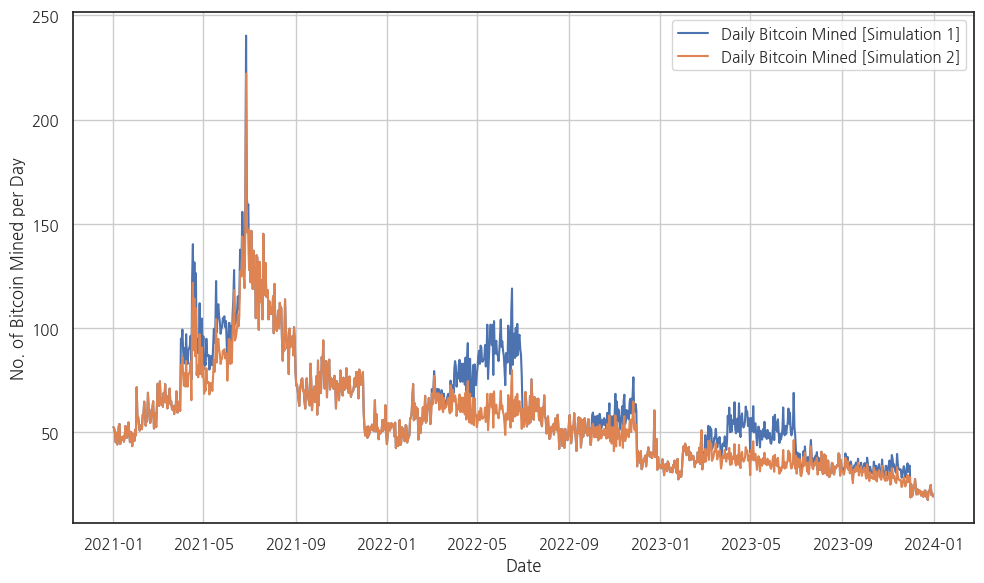

In [518]:
plt.figure(figsize=(10, 6))
plt.plot(merged_df['datetime'], merged_df['btc_per_day_sim1'], label='Daily Bitcoin Mined [Simulation 1]')
plt.plot(merged_df['datetime'], merged_df['btc_per_day_sim2'], label='Daily Bitcoin Mined [Simulation 2]')

plt.xlabel('Date')
plt.ylabel('No. of Bitcoin Mined per Day')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Calculating revenue per simulation

In [ ]:
simul_pred = pd.concat([
    pd.concat([pd.DataFrame(y_test[14:].reset_index(drop=False)), pd.DataFrame(y_pred[14:], columns=['rf_pred'])], axis=1),
    pd.DataFrame(y_pred_actual, columns=['LSTM_pred'])], axis=1)

In [534]:
simul_pred = pd.merge(simul_pred, merged_df[['datetime','market_price_usd', 'btc_per_day_sim1', 'btc_per_day_sim2']], how='left', left_on = 'index', right_on='datetime')
simul_pred['rev_real_sim1'] = simul_pred.apply(
    lambda row: row['market_price_usd']*row['btc_per_day_sim1'] , axis=1
)
simul_pred['rev_rf_sim1'] = simul_pred.apply(
    lambda row: row['rf_pred']*row['btc_per_day_sim1'] , axis=1
)
simul_pred['rev_lstm_sim1'] = simul_pred.apply(
    lambda row: row['LSTM_pred']*row['btc_per_day_sim1'] , axis=1
)

simul_pred['rev_real_sim2'] = simul_pred.apply(
    lambda row: row['market_price_usd']*row['btc_per_day_sim2'] , axis=1
)
simul_pred['rev_rf_sim2'] = simul_pred.apply(
    lambda row: row['rf_pred']*row['btc_per_day_sim2'] , axis=1
)
simul_pred['rev_lstm_sim2'] = simul_pred.apply(
    lambda row: row['LSTM_pred']*row['btc_per_day_sim2'] , axis=1
)

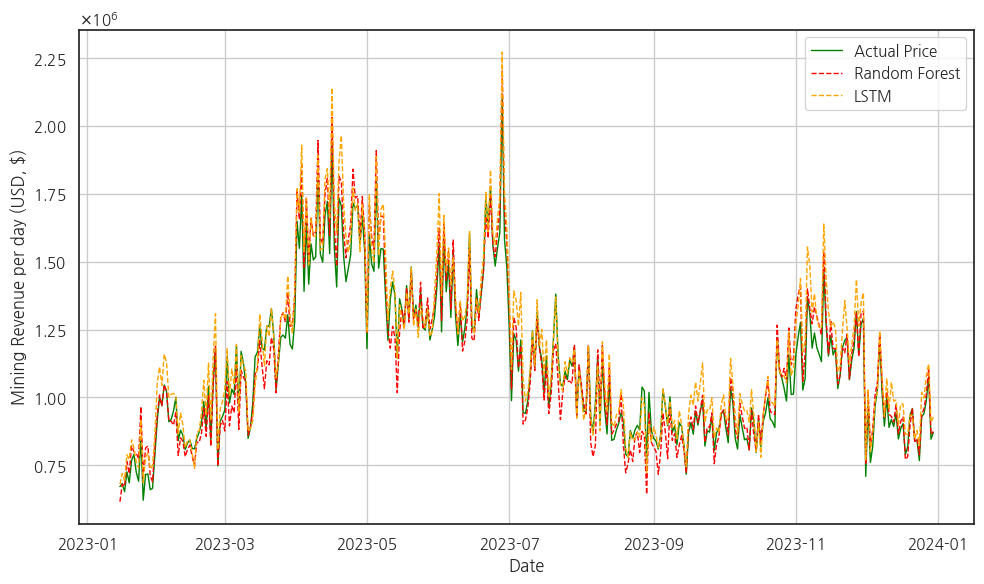

In [ ]:
# Visualization - Simulation 1
plt.figure(figsize=(10, 6))
plt.plot(simul_pred['datetime'], simul_pred['rev_real_sim1'], label='Actual Price', color='green', linewidth=1)
plt.plot(simul_pred['datetime'], simul_pred['rev_rf_sim1'], label='Random Forest', color='red', linestyle='--', linewidth=1)
plt.plot(simul_pred['datetime'], simul_pred['rev_lstm_sim1'], label='LSTM', color='orange', linestyle='--', linewidth=1)

ax = plt.gca()  # Customize y-axis
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((6, 6))
ax.yaxis.set_major_formatter(formatter)

plt.xlabel('Date')
plt.ylabel('Mining Revenue per day (USD, $)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

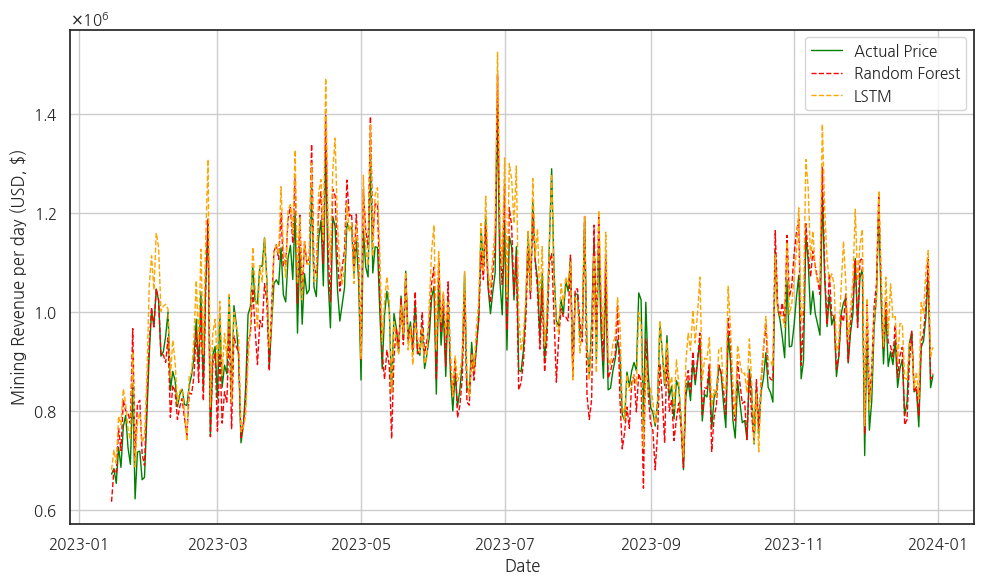

In [ ]:
# Visualization - Simulation 2
plt.figure(figsize=(10, 6))
plt.plot(simul_pred['datetime'], simul_pred['rev_real_sim2'], label='Actual Price', color='green', linewidth=1)
plt.plot(simul_pred['datetime'], simul_pred['rev_rf_sim2'], label='Random Forest', color='red', linestyle='--', linewidth=1)
plt.plot(simul_pred['datetime'], simul_pred['rev_lstm_sim2'], label='LSTM', color='orange', linestyle='--', linewidth=1)

ax = plt.gca()
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((6, 6))
ax.yaxis.set_major_formatter(formatter)

plt.xlabel('Date')
plt.ylabel('Mining Revenue per day (USD, $)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

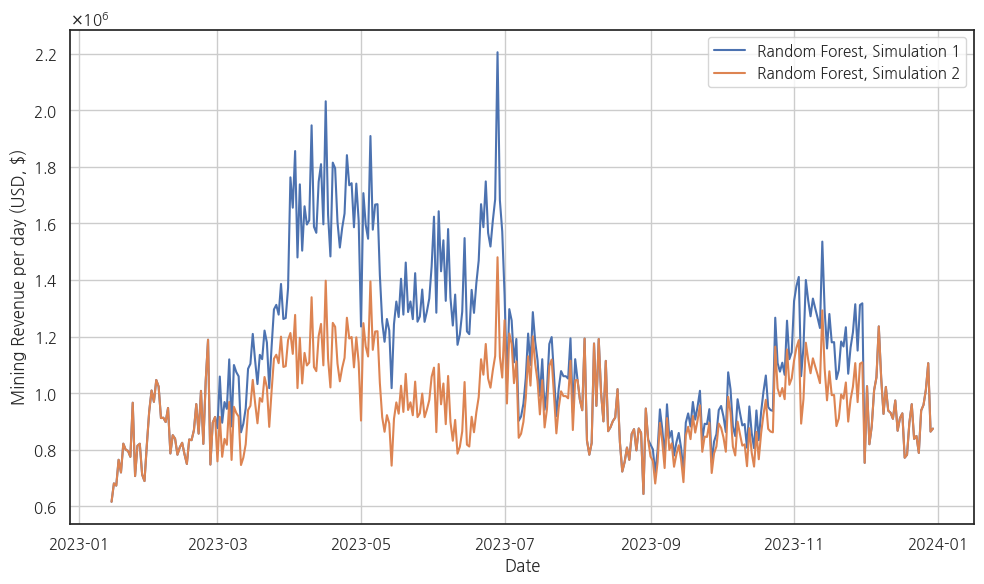

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(simul_pred['datetime'], simul_pred['rev_rf_sim1'], label='Random Forest, Simulation 1')
plt.plot(simul_pred['datetime'], simul_pred['rev_rf_sim2'], label='Random Forest, Simulation 2')

ax = plt.gca()
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((6, 6))
ax.yaxis.set_major_formatter(formatter)

plt.xlabel('Date')
plt.ylabel('Mining Revenue per day (USD, $)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Cost calculation
- Miner Cost
    - Lifespan of a miner is calculated to be 7.5 years (ref)

- Average distance between Seoul and the rest of the country
    - Seoul
        - Area: 605.2 km²
        - Number of substations: 51
        - Average distance: approx. 1.29 km.
    - Korea
        - Area: 100,210 km²
        - Number of substations: 900
        - Average distance: approx. 3.97 km.
- Electricity losses
    - Total power produced: 10,000 kWh
    - Transmission line loss rate: 0.2%/km, assuming a total of 5 km
    - Additional losses in low voltage sections: 5%.
        - Distance loss = 10,000*(0.2*5)=100
        - Low voltage loss = 10,000*5% = 500
        - Total loss = 100 + 500 = 600
- Not to Consider
    - Power Supply Unit (PSU)
    - Network equipment (high-speed router, switches, cables for internet connection, etc.)
    - Cost of replacing or repairing parts of the mining machine (fans, PSU, chips, etc.)
    - IT engineer or cooling system administrator may be required for larger operations
    - Space rent

In [ ]:
# Miner cost
miner_price_s21 = 10165 #$, Bitcoin Miner S21 XP Hyd
lifespan = 7.5

# Transmission and distribution loss rate
elecloss = 3.59

# Reference
- Bitcoin price
    - https://shop.bitmain.com/product/detail?pid=000202406200044065805TcPB8mt0682
- Bitcoin Miner Lifespan
    - https://www.cryptominerbros.com/blog/tips-to-expand-asic-miner-lifespan/?srsltid=AfmBOop8OcpYW9jTSWfdWWzesrCztqJstuqcdp6BWVvqyBjSFobGVUi-
- KEPCO Electricity Rates
    - https://online.kepco.co.kr/PRM004D00
- LSTM 
    - https://m.blog.naver.com/snowstormaw/222837950137
- MaraHoldings (Setting idle facilities to vary monthly, Updates for March 2024)
    - https://ir.mara.com/news-events/press-releases/detail/1351/marathon-digital-holdings-announces-bitcoin-production-and-mining-operation-updates-for-march-2024
- Electrical Distribution Course
    - https://www.a-ha.io/questions/4bf441c4dda35cce9d82ef5fa2af643a?utm_source=chatgpt.com
- Substation status
    - https://bigdata.kepco.co.kr/cmsmain.do?scode=S01&pcode=000319&pstate=L&redirect=Y
- Transmission and distribution losses
    - https://www.dnews.co.kr/uhtml/view.jsp?idxno=202210111358171470141